In [51]:
import numpy as np
import glob
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
# LOAD DATA
data_dir = "../data/Ns100_SeqN100/"
model_dir = "../Elman_SGD/Remap_predloss/N100T100/"

hidden_weight_inits = ["he", "shift", "cyclic-shift"]

Wh_list_he = glob.glob(model_dir + "he/hidden-weights/*")
Wh_list_shift = glob.glob(model_dir + "shift/hidden-weights/*")
Wh_list_cshift = glob.glob(model_dir + "cyclic-shift/hidden-weights/*")

he_path = model_dir + "he/Ns100_SeqN100_predloss_full.pth.tar"
shift_path = model_dir + "shift/Ns100_SeqN100_predloss_full.pth.tar"
cshift_path = model_dir + "cyclic-shift/Ns100_SeqN100_predloss_full.pth.tar"

he_data = torch.load(he_path)
shift_data = torch.load(shift_path)
cshift_data = torch.load(cshift_path)

In [53]:
def get_metrics_df(torch_data):
    metrics = torch_data["metrics"]
    met_df = pd.DataFrame(metrics)
    return met_df

In [ ]:
# final loss and best epoch
def final_loss_and_epoch(torch_data):
    loss_list = torch_data["loss"]
    final_loss = loss_list[-1]
    best_epoch = loss_list.index(min(loss_list))
    best_loss = float(min(loss_list))
    print(
        f"Final loss: {final_loss:.6f} | Best loss: {best_loss:.6f} at epoch {best_epoch}"
    )

    # return loss_list, final_loss, best_epoch, best_loss

In [56]:
final_loss_and_epoch(he_data)
final_loss_and_epoch(shift_data)
final_loss_and_epoch(cshift_data)

Final loss: 0.004846 | Best loss: 0.004846 at epoch 48179
Final loss: 0.004869 | Best loss: 0.004869 at epoch 42969
Final loss: 0.004795 | Best loss: 0.004795 at epoch 43234


He and shift hidden weight initialization reach a similar final loss, although shift is able to do it ~5k epochs sooner. Cyclic shift was able to reach a lower loss with a similar number of epochs to standard shift.

In [57]:
def plot_loss(torch_data):
    loss_list = torch_data["loss"]
    plt.figure(figsize=(6, 3))
    plt.plot(loss_list, lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title("Training Loss")
    plt.tight_layout()
    plt.show()

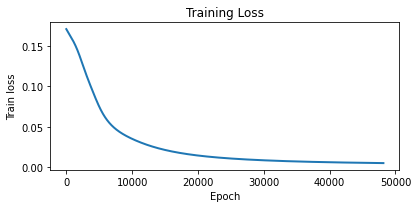

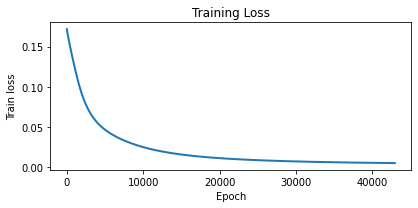

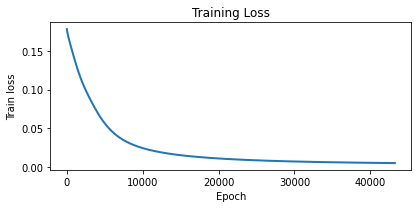

In [58]:
plot_loss(he_data)
plot_loss(shift_data)
plot_loss(cshift_data)

Shift loss and even moreso cyclic shift drop more sharply at the start then flattens with faster convergence compared to He initialization. This indicated that the structured initialization gives the RNN a built-in inductive bias.

In [59]:
print(he_data.keys())

dict_keys(['state_dict', 'loss', 'history', 'grad_list', 'metrics'])


In [60]:
he_data["history"].keys()

dict_keys(['epoch', 'y_hat', 'hidden', 'X_mini', 'Target_mini', 'loss', 'grad_norm'])

In [61]:
def plot_grad_norm(torch_data):
    history = torch_data["history"]
    plt.figure(figsize=(6, 3))
    plt.plot(history["epoch"], history["grad_norm"], marker="o")
    plt.xlabel("Epoch (recorded)")
    plt.ylabel("Grad norm (L2)")
    plt.title("Gradient Norm (recorded epochs)")
    plt.tight_layout()
    plt.show()

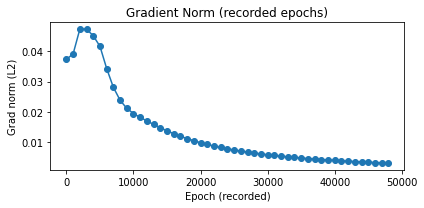

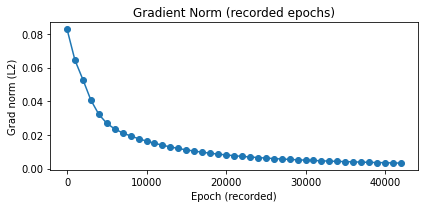

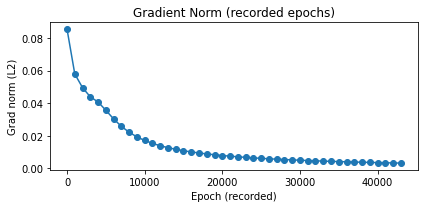

In [63]:
plot_grad_norm(he_data)
plot_grad_norm(shift_data)
plot_grad_norm(cshift_data)

He initialization has an early spike/overshoot followed by a long, smooth decay. The random eigenspectrum in He initialization gives mixed time scales, so the optimizer has to search more before settling. Due to more transient saturation and unstable directions, it needs more steps to stabilize. The shift initialization has a fast monotopic drop. The structured "conveyer belt" dynamics given an immediate bias for propgration, so gradients shrink quickly. The kink in the tail reflects learning to fix edge effects because of the boundaries in non-cyclic shift. The cyclic shift initialization has the fastest, smoothest decay. Being a permutation matrix (eigs on the unit circle) avoids edge effects and preserves signal energy uniformly around the ring leading to well-conditioned updates and minimal transient wobble.

In [65]:
# weight-dynamics diagnostics
he_metrics = get_metrics_df(he_data)
shift_metrics = get_metrics_df(shift_data)
cshift_metrics = get_metrics_df(cshift_data)

In [66]:
def plot_metrics(met_df):
    fig, axes = plt.subplots(2, 4, figsize=(16, 7), constrained_layout=True)
    axes = axes.ravel()

    # Define 7 line plots
    plots = [
        ("drift_from_init", "‖W_h − W_h(0)‖_F"),
        ("frob", "‖W_h‖_F"),
        ("spectral_radius", "Spectral radius ρ(W_h)"),
        ("orth_err", "‖W_hᵀ W_h − I‖_F"),
        ("act_mean", "mean(h)"),
        ("act_std", "std(h)"),
        ("tanh_sat", "tanh saturation frac"),
    ]
    i = 0

    for col, ylabel in plots:
        if (
            col in met_df.columns and met_df[col].notna().any() and i < len(axes) - 1
        ):  # leave last slot for scatter
            ax = axes[i]
            i += 1
            ax.plot(met_df["epoch"], met_df[col], marker="o")
            ax.set_title(ylabel)
            ax.set_xlabel("Epoch")
            ax.set_ylabel(ylabel)

    # Last panel: scatter Loss vs spectral radius (if available)
    if i < len(axes) and {"spectral_radius", "loss"}.issubset(met_df.columns):
        ax = axes[i]
        i += 1
        ax.scatter(met_df["spectral_radius"], met_df["loss"], s=20)
        ax.set_title("Loss vs ρ(W_h)")
        ax.set_xlabel("Spectral radius ρ(W_h)")
        ax.set_ylabel("Loss")

    # Turn off any leftover empty axes
    for k in range(i, len(axes)):
        axes[k].axis("off")

    plt.show()

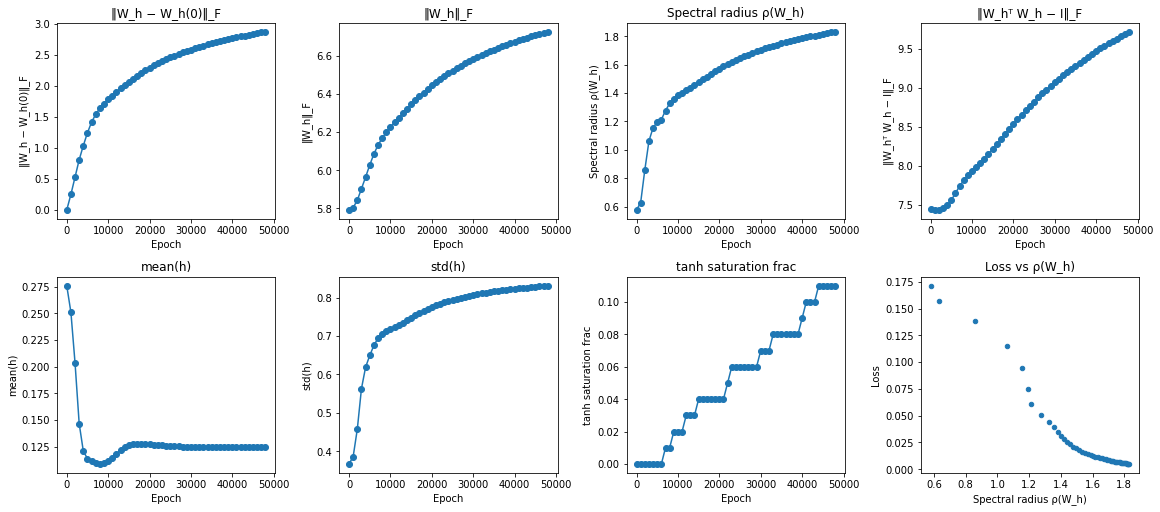

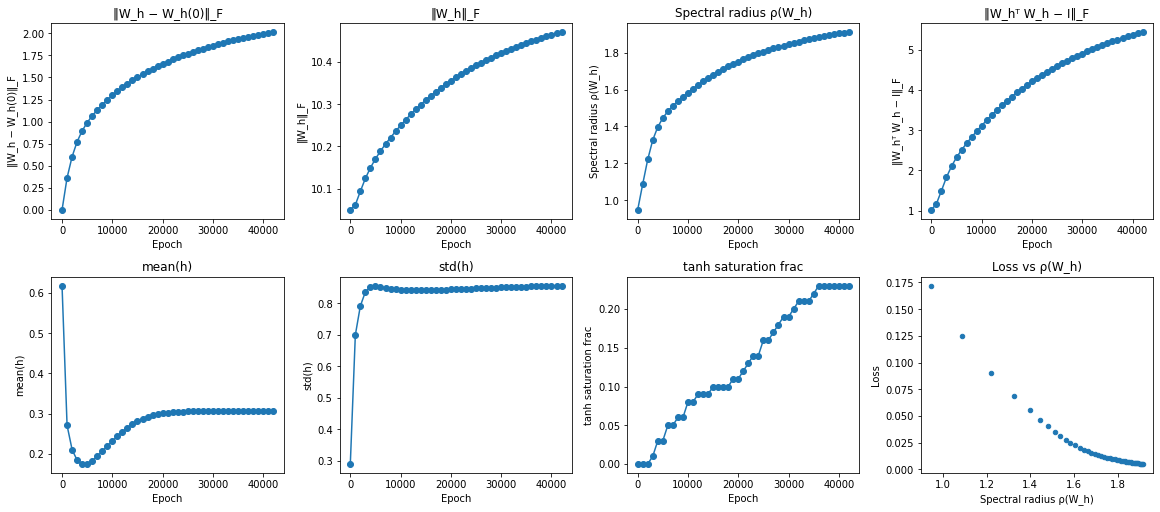

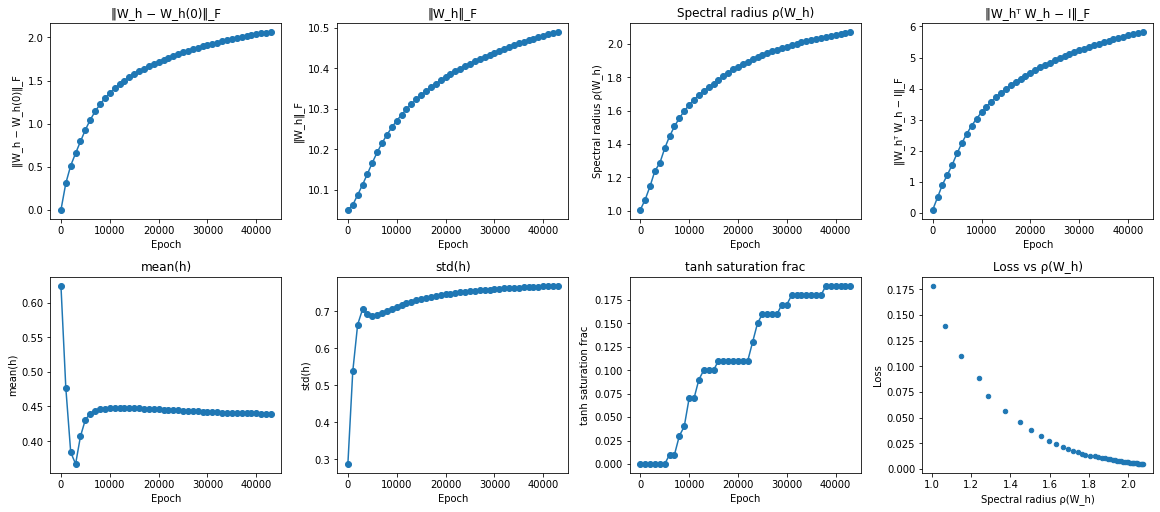

In [67]:
plot_metrics(he_metrics)
plot_metrics(shift_metrics)
plot_metrics(cshift_metrics)

1. Drift from initialization
    - Batch size 1 grows smoother and monotonically compared to bumpier batch size of 2. This suggests batch size 1 learns in a more consistent trajectory from initialization while batch size 2 takes a more erratic path.
2. Frobenius norm
    - Batch size 1 increases steadily and saturates while batch size 2 increases with more irregularity. The weight magnitudes stabilize better in batch size 1, indicating more controlled weight growth.
3. Spectral radius
    - Batch size 1 increases early then plateaus smoothly while batch size 2 shows strong oscillations before leveling. Spectral radius governs stability (exploding/vanishing dynamics), so batch size 1's smooth convergence means more stable hidden dynamics.
4. Orthogonality error
    - Batch size 1 decerases rapidly then has a smooth tail decay while batch size 2 drops sharply but fluctuates around a plateau. Orthogonal recurrent weights help preserve memory, so batch size 1 more cleanly moves toward this structure.
5. Activation std
    - Batch size 1 has smooth decay toward stable variance meaning is maintains healthier dynamic range of hidden activations.
    